As an aside, there is no ISO standard for quarters, but there is an EDTF recommended by the ISO format (see: https://en.wikipedia.org/wiki/ISO_8601#Standardised_extensions and https://www.loc.gov/standards/datetime/). Unfortunately, the datetime formats of Python don't recognize EDTF formats. Instead I'll be replacing the quarter designations with the month number for the first month in the quarter (e.g. 1 - January, 4 - April, etc)

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

bee_colony_data = pd.read_csv('bees_post_eda.csv')
bee_colony_data.head(n=5)

,State,year,quarter,Starting colonies,Maximum colonies,Lost colonies,Percent lost,Added colonies,Varroa mites,Other pests,Diseases,Pesticides,Other,Unknown,year_and_quarter,region,subregion
0,Alabama,2015,Q1,7000.0,7000.0,1800.0,26.0,2800.0,10.0,5.4,NaN,2.2,9.1,9.4,2015 Q1,south,east south central
1,Alabama,2015,Q2,7500.0,7500.0,860.0,12.0,1900.0,16.7,42.5,NaN,2.3,3.2,4.1,2015 Q2,south,east south central
2,Alabama,2015,Q3,8500.0,9000.0,1400.0,16.0,160.0,63.1,70.6,NaN,2.6,2.2,17.7,2015 Q3,south,east south central
3,Alabama,2015,Q4,8000.0,8000.0,610.0,8.0,80.0,3.1,6.4,0.2,0.2,2.8,1.9,2015 Q4,south,east south central
4,Alabama,2016,Q1,7500.0,7500.0,1700.0,23.0,1200.0,24.2,22.0,4.3,8.1,2.4,11.3,2016 Q1,south,east south central


## Data formatting

Convert year and quarter to datetime format

In [13]:
bee_colony_data['year_and_quarter'] = bee_colony_data['year_and_quarter'].str.replace(' Q1', '-01')
bee_colony_data['year_and_quarter'] = bee_colony_data['year_and_quarter'].str.replace(' Q2', '-04')
bee_colony_data['year_and_quarter'] = bee_colony_data['year_and_quarter'].str.replace(' Q3', '-07')
bee_colony_data['year_and_quarter'] = bee_colony_data['year_and_quarter'].str.replace(' Q4', '-10')

bee_colony_data['year_and_quarter'] = pd.to_datetime(bee_colony_data['year_and_quarter'], format='%Y-%m')
bee_colony_data.dtypes

State                        object
year                          int64
quarter                      object
Starting colonies           float64
Maximum colonies            float64
Lost colonies               float64
Percent lost                float64
Added colonies              float64
Varroa mites                float64
Other pests                 float64
Diseases                    float64
Pesticides                  float64
Other                       float64
Unknown                     float64
year_and_quarter     datetime64[ns]
region                       object
subregion                    object
dtype: object

## Index the categorical variables

In [14]:
states = bee_colony_data["State"].unique()
regions = bee_colony_data["region"].unique()
subregions = bee_colony_data["subregion"].unique()

state_map = {state:idx for idx, state in enumerate(states)}
region_map = {region:idx for idx, region in enumerate(regions)}
subregion_map = {subregion:idx for idx, subregion in enumerate(subregions)}

bee_colony_data["state_idx"] = bee_colony_data["State"].map(state_map)
bee_colony_data["region_idx"] = bee_colony_data["region"].map(region_map)
bee_colony_data["subregion_idx"] = bee_colony_data["subregion"].map(subregion_map)
bee_colony_data.head(n=5)

,State,year,quarter,Starting colonies,Maximum colonies,Lost colonies,Percent lost,Added colonies,Varroa mites,Other pests,Diseases,Pesticides,Other,Unknown,year_and_quarter,region,subregion,state_idx,region_idx,subregion_idx
0,Alabama,2015,Q1,7000.0,7000.0,1800.0,26.0,2800.0,10.0,5.4,NaN,2.2,9.1,9.4,2015-01-01,south,east south central,0,0,0
1,Alabama,2015,Q2,7500.0,7500.0,860.0,12.0,1900.0,16.7,42.5,NaN,2.3,3.2,4.1,2015-04-01,south,east south central,0,0,0
2,Alabama,2015,Q3,8500.0,9000.0,1400.0,16.0,160.0,63.1,70.6,NaN,2.6,2.2,17.7,2015-07-01,south,east south central,0,0,0
3,Alabama,2015,Q4,8000.0,8000.0,610.0,8.0,80.0,3.1,6.4,0.2,0.2,2.8,1.9,2015-10-01,south,east south central,0,0,0
4,Alabama,2016,Q1,7500.0,7500.0,1700.0,23.0,1200.0,24.2,22.0,4.3,8.1,2.4,11.3,2016-01-01,south,east south central,0,0,0


## Dummy variables / one-hot encoding

Create dummy variables for states, regions, and subregions

In [15]:
bee_data_encoded = pd.get_dummies(bee_colony_data, columns=['State', 'region', 'subregion'])

## Creating dependent variable columns

One of the 'Lost colonies' columns is NaN. It's for Hawaii in April. I used imputation with the mean to fill that in. 8 of the rows are missing Percent lost but have Lost colonies, so I calculated the 8 missing 'Percent lost' entries using that math.

Create calculated column of final colony count (Starting colonies - Lost colonies)

In [16]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_lost_col = imp_mean.fit_transform(bee_data_encoded['Lost colonies'].values.reshape(-1, 1))

bee_data_encoded['Lost colonies'] = imputed_lost_col

# Calculate the Percent lost for the 8 missing using the values from the Lost colonies
bee_data_encoded.loc[(bee_data_encoded['Percent lost'].isna()), 'Percent lost'] = bee_data_encoded['Lost colonies'] / bee_data_encoded['Starting colonies']

bee_data_encoded['Final colony count'] = bee_data_encoded['Starting colonies'] * (1 - (bee_data_encoded['Percent lost'] / 100))
bee_data_encoded['Log final to initial'] = np.log(bee_data_encoded['Final colony count'])

# Ensure that Percent lost missing data was filled and didn't affect the Final colony count and log columns
bee_data_encoded.isna().sum()

year                            0
quarter                         0
Starting colonies               0
Maximum colonies                0
Lost colonies                   0
                               ..
subregion_south atlantic        0
subregion_west north central    0
subregion_west south central    0
Final colony count              0
Log final to initial            0
Length: 77, dtype: int64

## Imputing

Impute missing data using sklearn SimpleImputer

In [17]:
scaled_col_names = ['Varroa mites', 'Other pests', 'Diseases', 'Pesticides', 'Other', 'Unknown']

imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imputed_cols = imp_median.fit_transform(bee_data_encoded[scaled_col_names])

bee_data_imputed = bee_data_encoded.copy()
bee_data_imputed[scaled_col_names] = imputed_cols
bee_data_imputed.head(n=5)

,year,quarter,Starting colonies,Maximum colonies,Lost colonies,Percent lost,Added colonies,Varroa mites,Other pests,Diseases,...,subregion_east south central,subregion_mid atlantic,subregion_mountain,subregion_new england,subregion_pacific,subregion_south atlantic,subregion_west north central,subregion_west south central,Final colony count,Log final to initial
0,2015,Q1,7000.0,7000.0,1800.0,26.0,2800.0,10.0,5.4,1.8,...,1,0,0,0,0,0,0,0,5180.0,8.552560
1,2015,Q2,7500.0,7500.0,860.0,12.0,1900.0,16.7,42.5,1.8,...,1,0,0,0,0,0,0,0,6600.0,8.794825
2,2015,Q3,8500.0,9000.0,1400.0,16.0,160.0,63.1,70.6,1.8,...,1,0,0,0,0,0,0,0,7140.0,8.873468
3,2015,Q4,8000.0,8000.0,610.0,8.0,80.0,3.1,6.4,0.2,...,1,0,0,0,0,0,0,0,7360.0,8.903815
4,2016,Q1,7500.0,7500.0,1700.0,23.0,1200.0,24.2,22.0,4.3,...,1,0,0,0,0,0,0,0,5775.0,8.661294


## Test / train split

Create a train and test split

In [18]:
X = bee_data_imputed.drop(['Final colony count', 'Log final to initial'], axis=1)
y = bee_data_imputed[['Final colony count', 'Log final to initial']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

y_train.head(n=5)

,Final colony count,Log final to initial
676,12555.0,9.437874
554,57000.0,10.950807
825,46500.0,10.747208
785,2755.0,7.921173
887,14720.0,9.596962


## Scaling

I researched each of the four scalers: StandardScaler, MaxAbsScaler, MinMaxScaler, and RobustScaler. I thought MaxAbsScaler looked like a good candidate because, per the documentation, it does not destroy any sparsity and this is fairly sparse data. However, since imputation has removed some of the sparsity, RobustScaler also looks like a good candidate because it uses the median instead of the mean and is thus less swayed by outliers. I considered MinMaxScaler, but I thought that would mask some of the large swings in the data. I decided to go ahead with RobustScaler in light of this evaluation, but I can change if my understanding is based on faulty assumptions.

Apply RobustScaler to the numeric columns after separating the dependent and target variables. Since I'm only scaling the pest variables, these are all on the same scale, so I'm applying the same transformation to each. 

Applying the scaling after train/test split to avoid leakage between datasets.

(array([[876.,  37.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [827.,  66.,  19.,   1.,   0.,   0.,   0.,   0.,   0.,   0.],
        [781.,  99.,  18.,   8.,   1.,   0.,   2.,   1.,   2.,   1.],
        [789., 103.,  15.,   4.,   2.,   0.,   0.,   0.,   0.,   0.],
        [828.,  73.,   9.,   3.,   0.,   0.,   0.,   0.,   0.,   0.],
        [807.,  90.,  12.,   2.,   2.,   0.,   0.,   0.,   0.,   0.]]),
 array([-1.01190476,  1.60693277,  4.22577031,  6.84460784,  9.46344538,
        12.08228291, 14.70112045, 17.31995798, 19.93879552, 22.55763305,
        25.17647059]),
 <a list of 6 BarContainer objects>)

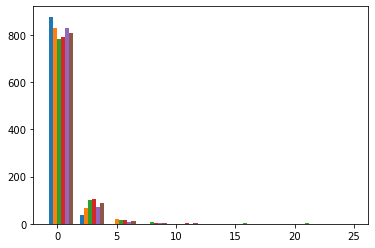

In [20]:
scaled_features_train = X_train[scaled_col_names]
scaler_train = RobustScaler()
scaled_bee_data_train = scaler_train.fit_transform(scaled_features_train.values)

scaled_features_test = X_test[scaled_col_names]
scaler_test = RobustScaler()
scaled_bee_data_test = scaler_test.fit_transform(scaled_features_test.values)

X_train[scaled_col_names] = scaled_bee_data_train
X_test[scaled_col_names] = scaled_bee_data_test

plt.hist(X_train[scaled_col_names])
# From the previous EDA, I know the numbers for varroa mites are much higher than the other causes of colony death
# I'm not sure if this means they are a different scale or not, though

In [21]:
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)
X.to_csv('X.csv', index=False)
y.to_csv('y.csv', index=False)
bee_data_encoded.to_csv('bee_data_after_preprocessing.csv', index=False)